# Accumulation Opportunities

Building VWAP algos given trades

In [154]:
import pandas as pd
import numpy as np
import h5py
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import matplotlib.pyplot as plt
import seaborn as sns

user_pause_time = 0.5

In [126]:
BTC_USD24 = '../data/2024-57__BTC-USD_trades.h5'
BTC_USD23 = '../data/trades_narrow_BTC-USD_2023.delim.gz'
BTC_USD22 = '../data/trades_narrow_BTC-USD_2022.delim.gz'

In [133]:
with h5py.File(BTC_USD24, "r") as h5_file:
    dataset = h5_file["BTC-USDTrades"]["BTC-USDTrades"][:]  # Extract as NumPy array

# Convert to DataFrame (if it's a structured array)
df2024 = pd.DataFrame(dataset)
df2024 = df2024.set_index('timestamp_utc_nanoseconds')


In [128]:
df2023 = pd.read_csv(BTC_USD23, sep='\t')

df2023 = df2023.set_index('timestamp_utc_nanoseconds')

In [143]:
df2022 = pd.read_csv(BTC_USD22, sep='\t')

display(df2022.head())

df2022 = df2022.set_index('timestamp_utc_nanoseconds')

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1643490176220148000,1643490169574850000,38383380000,938300,1.0
1,1643490176220541000,1643490169574850000,38387760000,8937830,1.0
2,1643490176220914000,1643490169574850000,38387770000,46454510,1.0
3,1643490176221462000,1643490169574850000,38388960000,14455400,2.0
4,1643490176221856000,1643490169574850000,38390720000,33673620,1.0


# VWAP Algorithm

In [273]:
def compute_min_size_t(df):
    """
    Compute the 5th percentile of trade sizes to determine `min_size_t`.
    """
    trade_sizes = df["SizeBillionths"] / 1e9  # Convert from billionths
    return np.percentile(trade_sizes, 5)  # 5th percentile

def vwap_algo(df, target_q, start_t, part_rate, quote_part_ratio, pause_time=0.05, crypto=False):
    """
    VWAP Participation Algorithm (Enhanced Version with Additional Metrics).

    - Computes `min_size_t` dynamically as the 5th percentile of trade sizes.
    - Executes trades sequentially while respecting `target_q`.
    - Applies pauses when ahead of execution schedule.
    - Calculates market VWAP during execution window.
    - Records arrival price at execution start.
    - Computes participation rate based on available liquidity.

    Parameters:
    - df: DataFrame with 'PriceMillionths', 'SizeBillionths', 'Side', indexed by 'received_utc_nanoseconds'
    - target_q: Target quantity Q.
    - start_t: Start time τs (nanoseconds).
    - part_rate: Target participation rate p.
    - quote_part_ratio: Quote adjusted participation rate k / target participation rate p.
    - pause_time: Pause time in seconds when ahead of schedule.
    - crypto: If True, apply crypto-to-crypto fees (0.1%), else apply fiat fees (0.5%).

    Returns:
    - DataFrame of executed trades.
    - VWAP price achieved.
    - Total execution time.
    - Market VWAP during execution.
    - Arrival price.
    - Participation rate.
    - Trading cost analysis.
    """

    quote_part_rate = quote_part_ratio * part_rate # this is k

    # Ensure the index is datetime-based
    df.index = pd.to_datetime(df.index, unit='ns')

    # Drop the timestamp column if it exists
    df = df.drop(columns=["received_utc_nanoseconds"], errors='ignore')

    # Filter trades based on start time
    df = df[df.index >= pd.to_datetime(start_t, unit='ns')]

    # Determine trade direction: Buy (Q > 0) or Sell (Q < 0)
    trade_sign = 1 if target_q > 0 else -1
    df = df[df['Side'] == -trade_sign]  # Keep only relevant trades

    if df.empty:
        print("No trades available after filtering. Check start_t or trade_side filters.")
        return {
            "executed_trades": pd.DataFrame(),
            "VWAP Price": np.nan,
            "Total Execution Time": None,
            "Market VWAP": np.nan,
            "Arrival Price": np.nan,
            "Participation Rate": np.nan,
            "Trading Cost": 0.0
        }

    # Compute the dynamic min_size_t (5th percentile of trade sizes)
    min_size_t = compute_min_size_t(df)
    print(f"Computed `min_size_t` (5th percentile): {min_size_t}")

    # Store arrival price (first trade price)
    arrival_price = df.iloc[0]["PriceMillionths"] / 1e6

    # Group by timestamp to process all trades at the same timestamp together
    grouped = df.groupby(df.index)

    # Initialize variables
    accumulated_q = 0
    executed_trades = []
    total_notional = 0
    last_trade_time = None
    total_available_liquidity = 0  # To calculate participation rate

    # Process trades sequentially
    for timestamp, trades_at_time in grouped:
        if accumulated_q >= abs(target_q):
            break  # Stop execution if target is reached

        # Enforce pause if needed
        if last_trade_time is not None and timestamp < last_trade_time + pd.Timedelta(seconds=pause_time):
            continue  # Skip trades during pause period

        # Aggregate trade sizes per price level
        trades_by_price = trades_at_time.groupby("PriceMillionths").sum(numeric_only=True)

        for price, row in trades_by_price.iterrows():
            q_level = row['SizeBillionths'] / 1e9  # Convert from billionths

            # Track available liquidity for participation rate calculation
            total_available_liquidity += q_level

            # Compute execution size per price level
            executed_size = max(0, (q_level - min_size_t) * quote_part_rate)

            # Prevent exceeding the target quantity
            if accumulated_q + executed_size > abs(target_q):
                executed_size = abs(target_q) - accumulated_q  # Trim excess execution

            if executed_size > 0:
                executed_trades.append((timestamp, price / 1e6, executed_size))  # Convert price from millionths
                accumulated_q += executed_size
                total_notional += executed_size * (price / 1e6)

        last_trade_time = timestamp  # Update last trade timestamp

    # Convert executed trades to a DataFrame
    executed_trades_df = pd.DataFrame(executed_trades, columns=['timestamp', 'price', 'size']).set_index('timestamp')

    if executed_trades_df.empty or executed_trades_df["size"].sum() == 0:
        print("No trades were executed.")
        return {
            "executed_trades": executed_trades_df,
            "VWAP Price": np.nan,
            "Total Execution Time": None,
            "Market VWAP": np.nan,
            "Arrival Price": arrival_price,
            "Participation Rate": np.nan,
            "Trading Cost": 0.0
        }

    # Compute VWAP price
    vwap_price = executed_trades_df['price'].dot(executed_trades_df['size']) / executed_trades_df['size'].sum()

    # Compute Market VWAP over execution window
    execution_window = df[df.index <= last_trade_time].copy()
    # integer overflow occurs, divide the price first

    execution_window['p'] = execution_window['PriceMillionths'] / 1_000_000
    execution_window['v'] = execution_window['SizeBillionths'] / 1_000_000_000
    market_vwap = (execution_window["p"] * execution_window["v"]).sum() / execution_window["v"].sum()

    # Compute Participation Rate
    participation_rate = accumulated_q / total_available_liquidity if total_available_liquidity > 0 else np.nan

    # Compute trading cost
    trading_fee_rate = 0.001 if crypto else 0.005
    trading_cost = total_notional * trading_fee_rate



    return {
        "executed_trades": executed_trades_df,
        "VWAP Price": vwap_price,
        "Total Execution Time": executed_trades_df.index[-1] - executed_trades_df.index[0] if not executed_trades_df.empty else None,
        "Market VWAP": market_vwap,
        "Arrival Price": arrival_price,
        "Participation Rate": participation_rate,
        "Trading Cost": trading_cost,
        'VWAP vs Market VWAP': trade_sign * (1 - vwap_price / market_vwap),
        'VWAP vs Arrival Price': trade_sign * (1 - vwap_price / arrival_price)
    }
 



# Analytics of the trade execution

In [178]:
def analyze_executed_trades(executed_trades_df):
    """
    Analyze the distribution of executed trade volumes and prices.
    
    Parameters:
    - executed_trades_df: DataFrame with 'price' and 'size' columns.
    
    Displays:
    - Histograms for trade volumes (log scale) and prices.
    - Summary statistics.
    """

    if executed_trades_df.empty:
        print("No executed trades to analyze.")
        return

    # Summary statistics
    volume_stats = executed_trades_df['size'].describe()
    price_stats = executed_trades_df['price'].describe()

    print("\nTrade Volume Statistics:")
    print(volume_stats)

    print("\nTrade Price Statistics:")
    print(price_stats)

    # Log-transform trade sizes to handle different magnitudes
    executed_trades_df["log_size"] = np.log1p(executed_trades_df["size"])  # log(1 + size) to avoid log(0)

    # Plot distribution of trade volumes (log scale)
    plt.figure(figsize=(12, 5))
    sns.histplot(executed_trades_df["log_size"], bins=30, kde=True, color="blue")
    plt.xlabel("Log-Scaled Trade Volume (log(1 + size))")
    plt.ylabel("Frequency")
    plt.title("Distribution of Trade Volumes (Log Scale)")
    plt.grid(True)
    plt.show()

    # Plot distribution of trade prices
    plt.figure(figsize=(12, 5))
    sns.histplot(executed_trades_df['price'], bins=30, kde=True, color="green")
    plt.xlabel("Trade Price")
    plt.ylabel("Frequency")
    plt.title("Distribution of Trade Prices")
    plt.grid(True)
    plt.show()


# Testing of the functions with a set of trades from each year

## 2023

In [276]:
res23 = vwap_algo(df2023, target_q=100, start_t=1674521267814309000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)


# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res23['VWAP Price']}")
print(f"Total Execution Time: {res23['Total Execution Time']}")
print(f"Market VWAP During Execution: {res23['Market VWAP']}")
print(f"Arrival Price: {res23['Arrival Price']}")
print(f"Participation Rate: {res23['Participation Rate']}")
print(f"Trading Cost: {res23['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res23['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res23['VWAP vs Arrival Price']}")

Computed `min_size_t` (5th percentile): 8.39e-06
VWAP Price Achieved: 23026.614776125625
Total Execution Time: 0 days 13:31:03.363736
Market VWAP During Execution: 23023.239696581277
Arrival Price: 22970.12
Participation Rate: 0.04984947975683648
Trading Cost: 11513.307388063135
VWAP improvement on Market VWAP: -0.00014659446667053544
VWAP improvement on Arrival Price: -0.002459489812226767



Trade Volume Statistics:
count    3.630700e+04
mean     2.754290e-03
std      6.928678e-03
min      5.000000e-10
25%      1.983498e-04
50%      6.252420e-04
75%      2.199581e-03
max      2.586128e-01
Name: size, dtype: float64

Trade Price Statistics:
count    36307.000000
mean     23021.170107
std         84.247814
min      22821.640000
25%      22937.765000
50%      23049.780000
75%      23093.690000
max      23165.190000
Name: price, dtype: float64


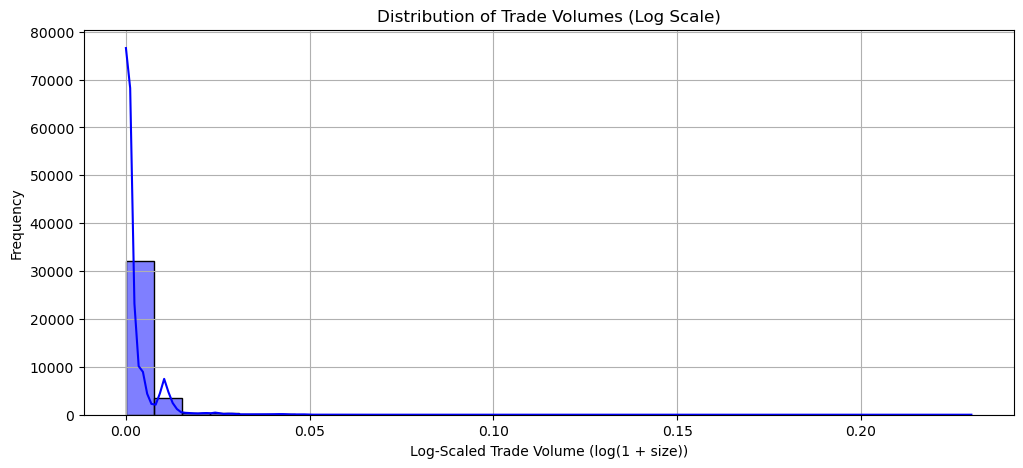

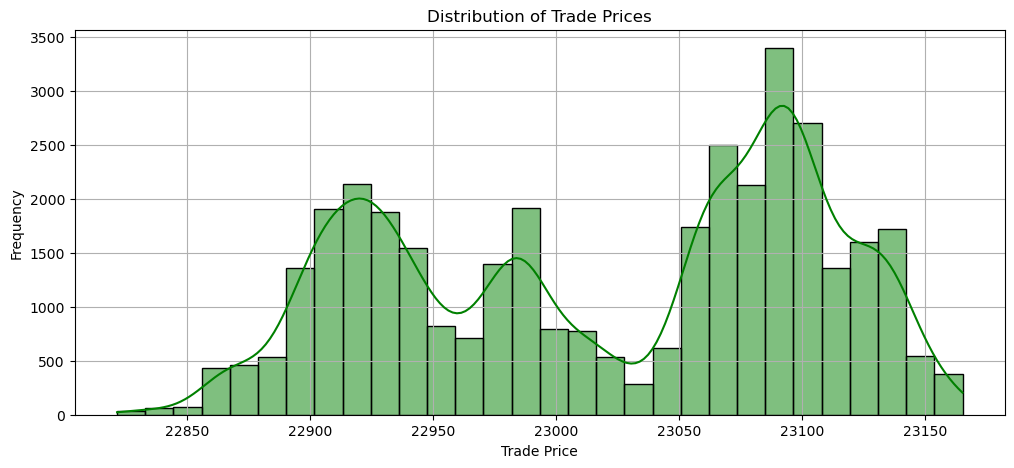

In [181]:
analyze_executed_trades(res23['executed_trades'])

# 2022

In [277]:
res24 = vwap_algo(df2024, target_q=100, start_t=1706390853901420000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)

# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res24['VWAP Price']}")
print(f"Total Execution Time: {res24['Total Execution Time']}")
print(f"Market VWAP During Execution: {res24['Market VWAP']}")
print(f"Arrival Price: {res24['Arrival Price']}")
print(f"Participation Rate: {res24['Participation Rate']}")
print(f"Trading Cost: {res24['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res24['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res24['VWAP vs Arrival Price']}")

Computed `min_size_t` (5th percentile): 3.5521e-05
VWAP Price Achieved: 42799.429205487984
Total Execution Time: 3 days 04:06:46.125409
Market VWAP During Execution: 42864.352751404585
Arrival Price: 42169.21
Participation Rate: 0.04995819793231625
Trading Cost: 262.40786661225053
VWAP improvement on Market VWAP: 0.001514627930885415
VWAP improvement on Arrival Price: -0.014945008585363295



Trade Volume Statistics:
count    5.610000e+02
mean     2.185778e-03
std      5.220868e-03
min      5.239500e-07
25%      7.322395e-05
50%      4.982240e-04
75%      1.946443e-03
max      5.949822e-02
Name: size, dtype: float64

Trade Price Statistics:
count      561.000000
mean     42732.186078
std        605.590265
min      41737.000000
25%      42210.860000
50%      42473.510000
75%      43352.960000
max      43752.490000
Name: price, dtype: float64


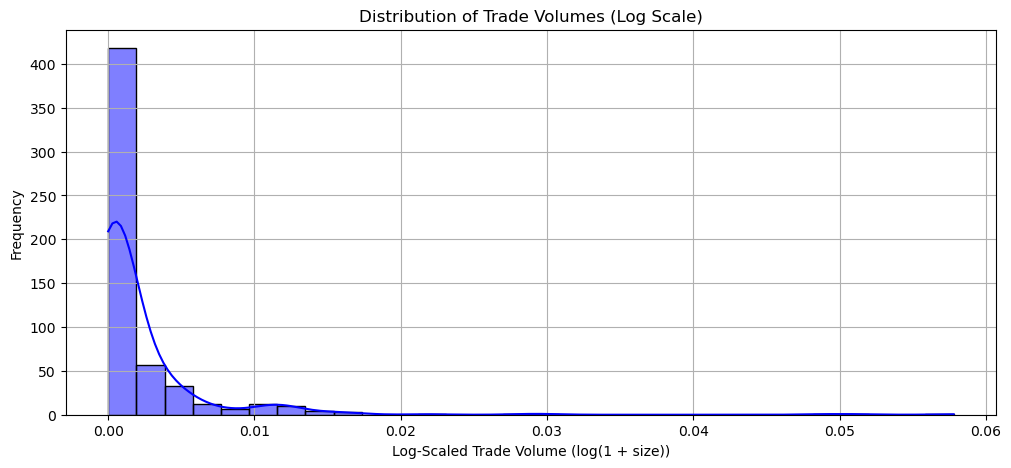

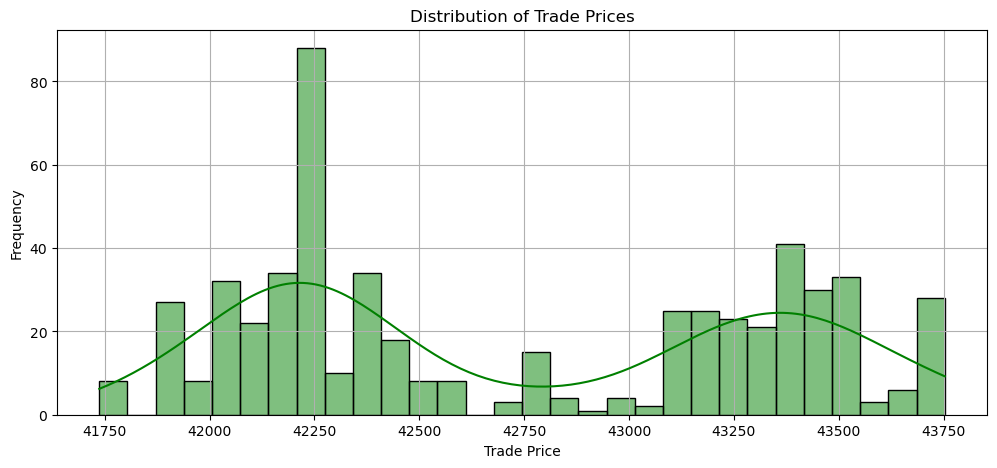

In [278]:
analyze_executed_trades(res24['executed_trades'])

# 2022

In [279]:
res22 = vwap_algo(df2022, target_q=100, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)

# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res22['VWAP Price']}")
print(f"Total Execution Time: {res22['Total Execution Time']}")
print(f"Market VWAP During Execution: {res22['Market VWAP']}")
print(f"Arrival Price: {res22['Arrival Price']}")
print(f"Participation Rate: {res22['Participation Rate']}")
print(f"Trading Cost: {res22['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res22['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res22['VWAP vs Arrival Price']}")

Computed `min_size_t` (5th percentile): 2.991e-05
VWAP Price Achieved: 37998.82628705499
Total Execution Time: 0 days 23:33:57.742436
Market VWAP During Execution: 37992.12471264382
Arrival Price: 38388.54
Participation Rate: 0.04993626668539658
Trading Cost: 18999.41314352695
VWAP improvement on Market VWAP: -0.00017639377796996314
VWAP improvement on Arrival Price: 0.01015182429300554



Trade Volume Statistics:
count    8.261900e+04
mean     1.210375e-03
std      7.939261e-03
min      1.000000e-09
25%      5.120400e-05
50%      3.237730e-04
75%      8.415680e-04
max      1.871399e+00
Name: size, dtype: float64

Trade Price Statistics:
count    82619.000000
mean     38014.799566
std        235.882626
min      37365.310000
25%      37907.230000
50%      38010.620000
75%      38144.690000
max      38738.360000
Name: price, dtype: float64


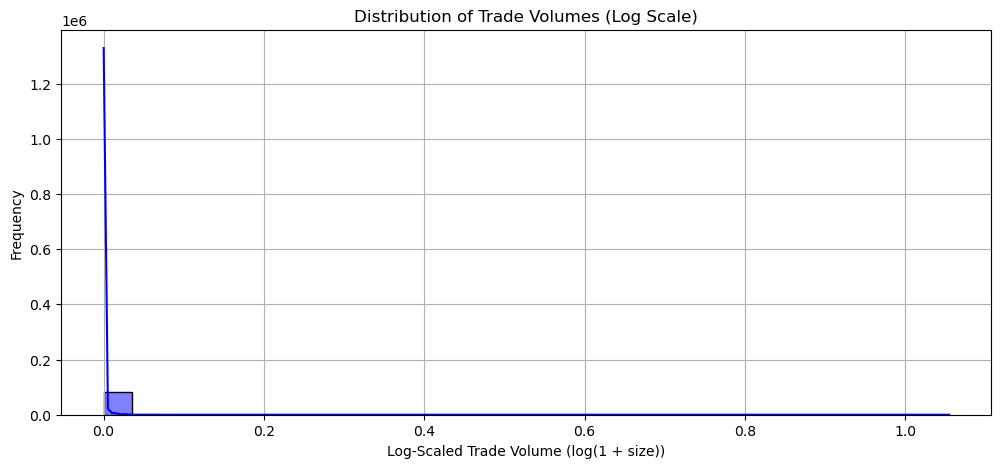

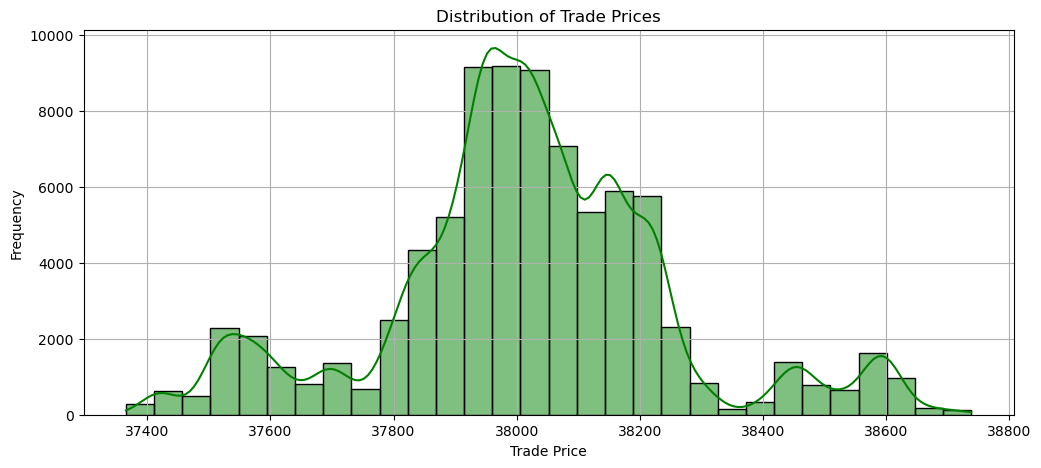

In [280]:
analyze_executed_trades(res22['executed_trades'])

## Commentary on Initial Analysis:

The VWAPs we execute are all relatively long and start at the beginning of the trading period. Interestingly, we see 2 modes in the distribution of trades made in 2023 and 2024 and a single mode for 2022. 

This is just the BTC and USD market so we can't comment on other markets but let's see if this persists.

I chose 100 shares because it seems to cover the entire time span.

First impression, our VWAP is not improving much upon the prices we are observing which is to be expected.

# Trade windows

We will now look for volumes such that we can can build the position in around 15 minutes

In [146]:
dict22 = {}
dict23 = {}
dict24 = {}

# second half is the crypto tag

delim_pairs = [('BTC-USD', False), ('ETH-BTC', True), ('ETH-USD', False)]
h5_pairs = [('BTC-USD', False), ('ETH-BTC', True), ('ETH-USD', False), ('SOL-ETH', True), ('SOL-USD', False)]



In [ ]:
with h5py.File(BTC_USD24, "r") as h5_file:
    dataset = h5_file["BTC-USDTrades"]["BTC-USDTrades"][:]  # Extract as NumPy array

# Convert to DataFrame (if it's a structured array)
df2024 = pd.DataFrame(dataset)
df2024 = df2024.set_index('timestamp_utc_nanoseconds')

df2023 = pd.read_csv(BTC_USD23, sep='\t')

df2023 = df2023.set_index('timestamp_utc_nanoseconds')

In [148]:
for pair, crypto in delim_pairs:
    path22 = f'../data/trades_narrow_{pair}_2022.delim.gz'
    path23 = f'../data/trades_narrow_{pair}_2023.delim.gz'

    df22 = pd.read_csv(path22, sep='\t').set_index('timestamp_utc_nanoseconds')
    df23 = pd.read_csv(path23, sep='\t').set_index('timestamp_utc_nanoseconds')

    dict22[pair] = (df22, crypto)
    dict23[pair] = (df23, crypto)

for pair, crypto in h5_pairs:
    path24 = f'../data/2024-57__{pair}_trades.h5'

    with h5py.File(path24, "r") as h5_file:
        dataset = h5_file[f"{pair}Trades"][f"{pair}Trades"][:]

    df24 = pd.DataFrame(dataset).set_index('timestamp_utc_nanoseconds')

    dict24[pair] = (df24, crypto)


## Look for volume windows for each df that yield desired time VWAP

### 2022

In [281]:
# BTC-USD: target quantity of 2
prod = 'BTC-USD'

res22 = vwap_algo(dict22[prod][0], target_q=2, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 2)

Computed `min_size_t` (5th percentile): 2.991e-05
Total Execution Time: 0 days 00:10:23.385795


In [282]:
# ETH-BTC: target quantity of 2
prod = 'ETH-BTC'

res22 = vwap_algo(dict22[prod][0], target_q=2, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 2)

Computed `min_size_t` (5th percentile): 0.00032227199999999997
Total Execution Time: 0 days 00:13:33.500286


In [283]:
# ETH-USD: target quantity of 1.4
# at 1.3, it takes 8 seconds
prod = 'ETH-USD'

res22 = vwap_algo(dict22[prod][0], target_q=1.4, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 1.4)

Computed `min_size_t` (5th percentile): 0.00037447
Total Execution Time: 0 days 00:00:24.681515


## 2023

In [284]:
# BTC-USD: target quantity of 2
prod = 'BTC-USD'

res23 = vwap_algo(dict23[prod][0], target_q=2, start_t=dict23[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 2)

Computed `min_size_t` (5th percentile): 8.39e-06
Total Execution Time: 0 days 00:12:47.979674


In [285]:
# ETH-BTC: target quantity of 1.2, large pockets of volume
# high variance in time 
prod = 'ETH-BTC'

res23 = vwap_algo(dict23[prod][0], target_q=1.2, start_t=dict23[prod][0].index[300], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 1.2)

Computed `min_size_t` (5th percentile): 1.1388000000000005e-05
Total Execution Time: 0 days 14:50:16.284373


In [286]:
# ETH-USD: target quantity of 10
prod = 'ETH-USD'

res23 = vwap_algo(dict23[prod][0], target_q=10, start_t=dict23[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 10)

Computed `min_size_t` (5th percentile): 4.25e-06
Total Execution Time: 0 days 00:06:25.949890


## 2024

In [ ]:
# BTC-USD: target quantity of 0.005
# volumes are chunky and high variance
prod = 'BTC-USD'

res24 = vwap_algo(dict24[prod][0], target_q=0.005, start_t=dict24[prod][0].index[300], part_rate=0.02, quote_part_rate=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.005)

Computed `min_size_t` (5th percentile): 3.163100000000001e-05
Total Execution Time: 0 days 00:59:41.715395


In [287]:
# ETH-BTC: target quantity of 0.1
# volumes are chunky and high variance
prod = 'ETH-BTC'

res24 = vwap_algo(dict24[prod][0], target_q=0.1, start_t=dict24[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.1)

Computed `min_size_t` (5th percentile): 0.01
Total Execution Time: 0 days 02:53:21.655516


In [289]:
# BTC-USD: target quantity of 0.1
# volumes are chunky and high variance
prod = 'ETH-USD'

res24 = vwap_algo(dict24[prod][0], target_q=0.1, start_t=dict24[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.1)

Computed `min_size_t` (5th percentile): 2.655e-05
Total Execution Time: 0 days 01:00:08.178191


In [268]:
# SOL-USD: target quantity of 2
# volumes are chunky and high variance
prod = 'SOL-USD'

res24 = vwap_algo(dict24[prod][0], target_q=2, start_t=dict24[prod][0].index[400], part_rate=0.02, quote_part_rate=0.05, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 2)

Computed `min_size_t` (5th percentile): 0.023700000000000002
Total Execution Time: 0 days 01:59:26.547012


In [290]:
# SOL-ETH: target quantity of 2
prod = 'SOL-ETH'

res24 = vwap_algo(dict24[prod][0], target_q=2, start_t=dict24[prod][0].index[400], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 2)

Computed `min_size_t` (5th percentile): 0.08
Total Execution Time: 0 days 00:39:03.035176


## Commentary on parameter initialization

It seems as though we are taking relatively low volumes. However, there are points in the dataset with relatively large volumes occurring as we see chunky changes in the time it takes to attain just 0.1 more shares of volume in our VWAP. 

Our volume selection may not be the most optimal in this aspect given a randomization in time selection.

# Analysis

I will take random samples of size 60. This is mainly trying to maintain independence.

## What factors am I looking for?

VWAP vs Market VWAP and Arrival Price

Real Participation Rate vs Target Participation Rate (depending on k)

